In [1]:
import numpy as np
from scipy.integrate import odeint
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)

# import the function we want from that file
from plot_utility import plot_tme

# Nominal trajectory, measurements

In [3]:
class MonoCamera:
    def __init__(self):
        self.std = 0.1
        self.v = scipy.stats.norm(0, self.std)
        
    def control(self, X, t):
        u_g = np.sin(0.2*t)
        return u_g
    
    def f(self, X, t):
        g, d = X
        # control
        u_g = self.control(X, t)
        # dynamics
        g_dot = u_g
        d_dot = 0
        x_dot = [g_dot, d_dot]
        return x_dot
    
    def h(self, X, t):
        g, d = X
        u_g = self.control(X, t)
        y = np.array([g/d + self.v.rvs(g.shape) ])
        return y
    
    def simulate(self, x0, tsim):
        result = odeint(self.f, x0, tsim)
        X = result.T
        U = np.atleast_2d(self.control(X, tsim))
        Y = self.h(X, tsim)
        return X, U, Y

In [4]:
sys = MonoCamera()

x0 = np.array([0, 3])
tsim = np.arange(0, 100, 0.01)

X, U, Y = sys.simulate(x0, tsim)

In [5]:
print(X.shape)
print(Y.shape)
print(U.shape)

(2, 10000)
(1, 10000)
(1, 10000)


Text(0, 0.5, 'Measurement values')

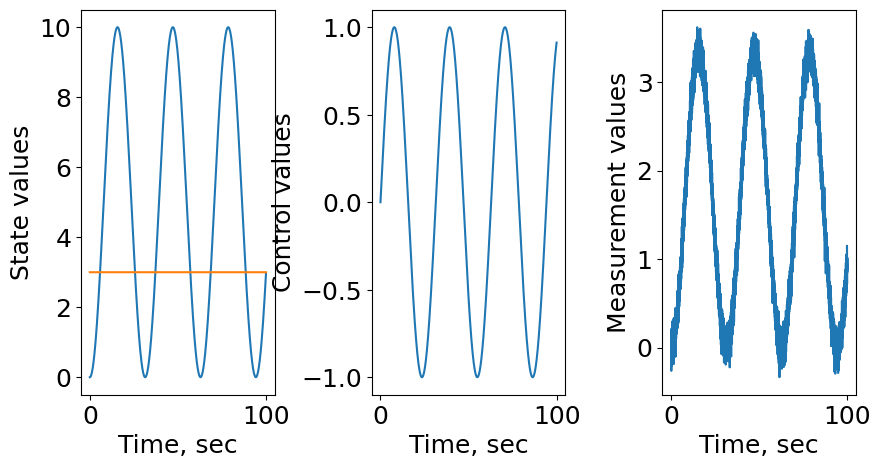

In [6]:
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(wspace=0.5)

# States
ax = fig.add_subplot(131)

ax.plot(tsim, X[0,:])
ax.plot(tsim, X[1,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('State values')

# Controls
ax = fig.add_subplot(132)

ax.plot(tsim, U[0,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('Control values')

# Measurements
ax = fig.add_subplot(133)

ax.plot(tsim, Y[0,:])
#ax.plot(tsim, Y[1,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('Measurement values')

# Initial conditions

In [7]:
# Initial conditions
x0 = np.array([[1], [5]])
P0 = 10*np.eye(2)

# Noise defined by measurement noise
R = sys.std**2*np.eye(1)

# Fairly accurate model
Q = 1e-3*np.eye(2)

# Unscented Kalman Filter

Note: this UKF function expects everything to be given as 2D matrices

In [8]:
#!pip install git+https://github.com/florisvb/pyUKFsqrt.git

In [9]:
import ukf_sqrt

In [10]:
def f_d(X, U, w):
    dt=0.01
    g = X[0,0]
    d = X[1,0]
    g_dot = U[0,0]
    d_dot = 0
    x_new = np.matrix([g + g_dot*dt, d + d_dot*dt]).T + w
    return x_new

def h_d(X, U, v):
    g = X[0,0]
    d = X[1,0]
    y = np.matrix( g/d ).T + v
    return y

In [11]:
xhat, P, s, sigma_points = ukf_sqrt.ukf_sqrt(np.matrix(Y), np.matrix(x0), 
                               f_d, h_d, 
                               np.matrix(Q), 
                               np.matrix(R), 
                               np.matrix(U), 
                               None, 
                               return_sigma_points=True)

<Axes: xlabel='Time', ylabel='x1'>

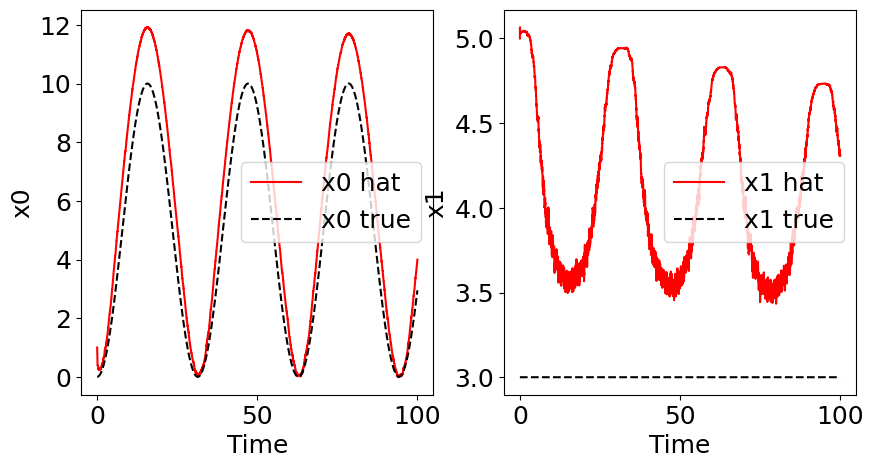

In [12]:
fig = plt.figure(figsize=(10,5))


ax = fig.add_subplot(121)
plot_tme(tsim, X[0,:].T, None, xhat[0,:].T, ax=ax, label_var='x0')

ax = fig.add_subplot(122)
plot_tme(tsim, X[1,:].T, None, xhat[1,:].T, ax=ax, label_var='x1')


# Show sigma points

(-0.001, 0.001)

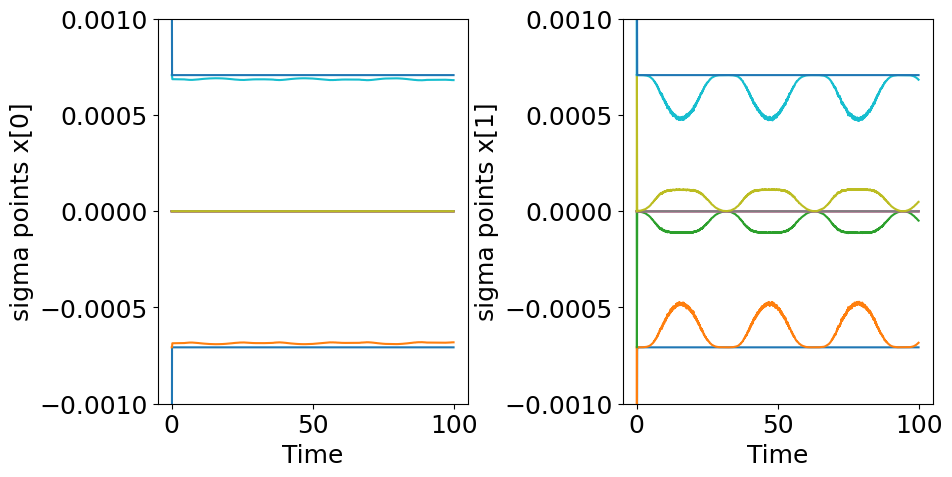

In [13]:
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(wspace=0.5)

state = 0
ax = fig.add_subplot(121)
ax.set_ylabel('sigma points x[0]')
ax.set_xlabel('Time')
for i in range(sigma_points.shape[1]):
    ax.plot(tsim[1:],  (sigma_points[state,i,:] - np.mean(sigma_points[state,:,:], axis=0) ) )
ax.set_ylim(-1*Q[state,state], Q[state,state])

state = 1
ax = fig.add_subplot(122)
ax.set_ylabel('sigma points x[1]')
ax.set_xlabel('Time')
for i in range(sigma_points.shape[1]):
    ax.plot(tsim[1:],  (sigma_points[state,i,:] - np.mean(sigma_points[state,:,:], axis=0) ) )
ax.set_ylim(-1*Q[state,state], Q[state,state])
